In [1]:
import torch
import numpy as np
import pickle
import os
from openai import OpenAI
from omegaconf import OmegaConf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
with open("../data/190325_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [ ]:
messages = []
labels = []
game_ids = []
user_ids = []
languages = []
for game_id, game_data in chat_data.items():
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        user_ids.append(message["userID"])
        if game_data["language"] is None:
            languages.append("en")
        else:
            languages.append(game_data["language"])
        
print(len(messages))
print(len(labels))

2024-08-27 09:48:06
2024-08-27 09:48:08
2024-08-27 09:48:11
2024-08-27 09:48:17
2024-08-27 09:48:21
2024-08-27 09:48:32
2024-08-27 09:48:43
2024-08-27 09:48:52
2024-08-27 09:48:55
2024-08-27 09:49:08
2024-08-27 09:49:20
2024-08-27 09:49:47
2024-08-27 09:49:58
2024-08-27 09:50:05
2024-08-27 09:50:10
2024-08-27 09:48:20
2024-08-27 09:48:23
2024-08-27 09:48:37
2024-08-27 09:48:56
2024-08-27 09:48:57
2024-08-27 09:49:05
2024-08-27 09:49:20
2024-08-27 09:49:23
2024-08-27 09:49:35
2024-08-27 09:49:50
2024-08-27 09:49:56
2024-08-27 09:50:08
2024-08-27 09:50:10
2024-08-27 09:50:21
2024-08-27 09:50:26
2024-08-27 09:51:05
2024-08-27 09:51:20
2024-08-27 09:51:33
2024-08-27 09:52:55
2024-08-27 09:52:56
2024-08-27 09:53:08
2024-08-27 09:53:36
2024-08-27 09:53:47
2024-08-27 09:53:54
2024-08-27 09:54:06
2024-08-27 09:54:36
2024-08-27 09:55:51
2024-08-27 09:56:01
2024-08-27 09:56:06
2024-08-27 09:56:42
2024-08-27 09:56:54
2024-08-27 09:57:03
2024-08-27 09:57:36
2024-08-27 09:58:03
2024-08-27 09:58:08


In [ ]:
class Classifier:
    def __init__(self, path_to_state_dict):
        class MessageClassifier(torch.nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
                super().__init__()
                self.activation = torch.nn.ReLU()
                layers = []
                current_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(torch.nn.Linear(current_size, hidden_size))
                    layers.append(torch.nn.BatchNorm1d(hidden_size))
                    layers.append(torch.nn.ReLU())
                    layers.append(torch.nn.Dropout(dropout))
                    current_size = hidden_size
                layers.append(torch.nn.Linear(current_size, output_size))
        
                self.model = torch.nn.Sequential(*layers)
        
            def forward(self, x):
                return self.model(x)

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # This code will only run on the Turing Game server. It is included in the repo for completeness
        self.client = OpenAI(
                            api_key="EMPTY",
                            base_url="http://localhost:8000/v1"
                        )
        self.embedding_model = "intfloat/multilingual-e5-large-instruct"

        self.classifier = MessageClassifier(1024, [512, 128, 32], 2, dropout=0.75)
        self.classifier.to(self.device)
        self.classifier.load_state_dict(torch.load(path_to_state_dict, weights_only=True))
        self.classifier.eval()

    def predict(self, message: str):
        embedding = torch.tensor(self.client.embeddings.create(input = [message], model=self.embedding_model).data[0].embedding)
        pred = self.classifier(embedding.unsqueeze(dim=0)).squeeze()
        return torch.tanh(pred[1]-pred[0]).item()
            

In [ ]:
classifier = Classifier("../trained_models/run20.pth")

In [7]:
messages_with_how_about_you= []
user_ids_with_how_about_you = []
messages_with_hbu = []
user_ids_with_hbu = []
for message, user_id in zip(messages, user_ids):
    if "how about you" in message:
        messages_with_how_about_you.append(message)
        user_ids_with_how_about_you.append(user_id)
    
    if "hbu" in message:
        messages_with_hbu.append(message)
        user_ids_with_hbu.append(user_id)

In [8]:
for user_id, message in zip(user_ids_with_how_about_you[-3:-1], messages_with_how_about_you[-3:-1]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("how about you", "hbu"))
    print(classifier.predict(message.replace("how about you", "hbu")))

im good how about you
0.9780312776565552
After changing
im good hbu
-0.9999995827674866
im from canada how about you purple
0.9857386946678162
After changing
im from canada hbu purple
0.4484865367412567


In [9]:
for user_id, message in zip(user_ids_with_hbu[-2:], messages_with_hbu[-2:]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("hbu", "how about you"))
    print(classifier.predict(message.replace("hbu", "how about you")))

hbu
-1.0
After changing
how about you
-0.815436065196991
doing good hbu
-0.9998932480812073
After changing
doing good how about you
0.9895229339599609


In [10]:
classifier.predict("im from the city how about you")

0.9988409280776978

In [11]:
classifier.predict("im from the city hbu")

0.9948358535766602

In [12]:
messages_with_dot= []
user_ids_with_dot = []
messages_with_three_dots = []
user_ids_with_three_dots = []
for message, user_id in zip(messages, user_ids):
    if "." in message:
        messages_with_dot.append(message)
        user_ids_with_dot.append(user_id)
    if "..." in message:
        messages_with_three_dots.append(message)
        user_ids_with_three_dots.append(user_id)

In [13]:
for user_id, message in zip(user_ids_with_three_dots[-5:], messages_with_three_dots[-5:]):
    print(f"{user_id}: {message}")

QcXSNiZGWxMJhQog: okay puple, just for your information: yellow is the bot .... ;-)
QcXSNiZGWxMJhQog: okay, that's correct ...
TOnJ7DoQy14aIvNp: yes where is blue...
0: das ist komisch, blue, deine letzten paar buchstaben konnte ich nciht lesen... was hast du denn geschrieben?
2xZn8nt3B2QqW5xA: your are so lousy bots ....


In [14]:
classifier.predict("das ist komisch, blue, deine letzten paar buchstaben konnte ich nciht lesen. was hast du denn geschrieben?")

0.9999949336051941

In [15]:
classifier.predict("das ist komisch, blue, deine letzten paar buchstaben konnte ich nciht lesen... was hast du denn geschrieben?")

0.999986469745636

In [16]:
random.seed(42)
n = 0
for idx in range(len(messages)-1, 0, -1):
    if user_ids[idx] == '0':
        if len(messages[idx].split(" ")) > 5:
            continue
        if messages[idx].split(" ")[0] == "hey" or messages[idx].split(" ")[0] == "hey,":
            continue
        if messages[idx][-1] != "?":
            continue
        print(messages[idx])
        print(classifier.predict(messages[idx]))
        print("After changing")
        print(f"hey {messages[idx]}")
        print(classifier.predict(f"hey {messages[idx]}"))
        n += 1
    if n == 4:
        break

So what's the plan then?
0.9997361302375793
After changing
hey So what's the plan then?
0.9984922409057617
Not really, maybe 30 minutes?
-0.45445773005485535
After changing
hey Not really, maybe 30 minutes?
-0.8108595013618469
so who's bored rn?
0.7098991870880127
After changing
hey so who's bored rn?
0.9952754974365234
lol bots?
0.9592686295509338
After changing
hey lol bots?
-0.48203447461128235


In [17]:
messages_with_hi= []
user_ids_with_hi = []
for message, user_id in zip(messages, user_ids):
    if "hi " in message or "hi," in message:
        messages_with_hi.append(message)
        user_ids_with_hi.append(user_id)

In [18]:
for user_id, message in zip(user_ids_with_hi[-4:], messages_with_hi[-4:]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("hi", "hey"))
    print(classifier.predict(message.replace("hi", "hey")))

hi, who aree you
-1.0
After changing
hey, who aree you
-1.0
hi there
0.18446418642997742
After changing
hey there
0.6552844047546387
hi boys and girls
-1.0
After changing
hey boys and girls
-0.9999581575393677
hi guys
-0.9999998807907104
After changing
hey guys
-0.99979168176651


In [ ]:
def evaluate_on_old_games(classifier, threshold=1):
    with open("data/190325_data.pkl", "rb") as f:
        chat_data = pickle.load(f)

    with open("data/games_not_trained_on.pkl", "rb") as f:
        val_games = pickle.load(f)

    true_positives = 0
    false_positives = 0
    false_game_ids = []
    false_negative = 0

    for game_id in tqdm(val_games, desc="Evaluating", total=len(val_games)):
        # Retrieve game
        game = chat_data[game_id]
        player_scores = defaultdict(float)
        # Calculate Scores
        for message in game["messages"]:
            if message["userID"] == "GameMaster":
                if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                    break
                else:
                    continue
            else:
                if message["botID"]:
                    player_scores["bot"] += classifier.predict(message["message"])
                else:
                    player_scores[message["color"]] += classifier.predict(message["message"])

        colors = list(player_scores.keys())
        if "bot" not in player_scores.keys():
            player_scores["bot"] = 0
        while len(player_scores.keys()) < 3:
            player_scores[f"simulated_player_{3-len(player_scores.keys())}"] = 0
            
        colors = list(player_scores.keys())
        for player in colors:
            if player == "bot":
                continue

            bot_score = player_scores["bot"]
            human_score = player_scores[player]

            if bot_score - human_score > threshold:
                # Classifier would accuse the bot
                true_positives += 1
            elif human_score - bot_score > threshold:
                # Classifier would wrongly accuse a human
                false_positives += 1
                false_game_ids.append(game_id)
            else:
                # No accusation: could be FN or TN
                false_negative += 1
                false_game_ids.append(game_id)
    return true_positives, false_positives, false_negative, false_game_ids

In [20]:
def get_player_scores(classifier, threshold=1):
    with open("data/190325_data.pkl", "rb") as f:
        chat_data = pickle.load(f)

    with open("data/games_not_trained_on.pkl", "rb") as f:
        val_games = pickle.load(f)

    player_scores_per_game = []
    for game_id in tqdm(val_games, desc="Evaluating", total=len(val_games)):
        # Retrieve game
        game = chat_data[game_id]
        player_scores = defaultdict(float)
        # Calculate Scores
        for message in game["messages"]:
            if message["userID"] == "GameMaster":
                if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                    break
                else:
                    continue
            else:
                if message["botID"]:
                    player_scores["bot"] += classifier.predict(message["message"])
                else:
                    player_scores[message["color"]] += classifier.predict(message["message"])        

        if "bot" not in player_scores.keys():
            player_scores["bot"] = 0
        while len(player_scores.keys()) < 3:
            player_scores[f"simulated_player_{3-len(player_scores.keys())}"] = 0
        
        player_scores_per_game.append(player_scores)
    return player_scores_per_game, val_games

In [21]:
tp, fp, fn, false_game_ids_threshold_3= evaluate_on_old_games(classifier, threshold=3)

Evaluating: 100%|██████████| 228/228 [04:41<00:00,  1.23s/it]


In [22]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0

In [23]:
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")

True Positives (TP):          326
False Positives (FP):         0
False Negatives (FN):         130

Precision:                    1.0000
Recall (TPR):                 0.7149
F1 Score:                     0.8338
False Discovery Rate (FDR):   0.0000
Miss Rate (FNR):              0.2851


In [24]:
tp, fp, fn, false_game_ids_threshold_1 = evaluate_on_old_games(classifier, threshold=1)

Evaluating: 100%|██████████| 228/228 [04:40<00:00,  1.23s/it]


In [25]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0

In [26]:
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")

True Positives (TP):          413
False Positives (FP):         2
False Negatives (FN):         41

Precision:                    0.9952
Recall (TPR):                 0.9097
F1 Score:                     0.9505
False Discovery Rate (FDR):   0.0048
Miss Rate (FNR):              0.0903


In [27]:
with open("data/false_game_ids_threshold_1.pkl", "wb") as f:
    pickle.dump(false_game_ids_threshold_1, f)
with open("data/false_game_ids_threshold_3.pkl", "wb") as f:
    pickle.dump(false_game_ids_threshold_3, f)

In [28]:
player_scores_per_game, game_ids = get_player_scores(classifier)

Evaluating: 100%|██████████| 228/228 [04:42<00:00,  1.24s/it]


In [ ]:
def evaluate_threshold_curve(player_scores_per_game):
    thresholds = np.linspace(0, 5, 100)
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        tp = 0
        fp = 0
        fn = 0

        for scores in player_scores_per_game:
            bot_score = scores["bot"]
            for player, human_score in scores.items():
                if player == "bot":
                    continue

                if bot_score - human_score > threshold:
                    tp += 1
                elif human_score - bot_score > threshold:
                    fp += 1
                else:
                    fn += 1

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)


    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.plot(thresholds, f1_scores, label="F1 Score", color='red')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Classifier Performance vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return thresholds, precisions, recalls, f1_scores

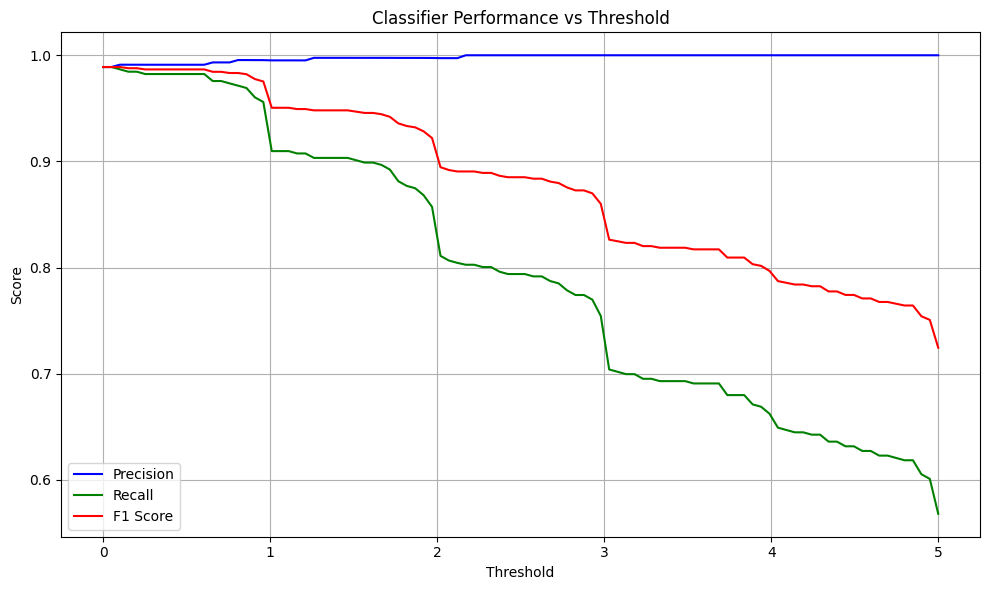

In [30]:
thresholds, precisions, recalls, f1_scores = evaluate_threshold_curve(player_scores_per_game)

In [31]:
with open("data/val_games_player_scores.pkl", "wb") as f:
    pickle.dump(player_scores_per_game, f)

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def evaluate_thresholds_roc(player_scores_per_game, threshold_list):
    score_diffs = []
    labels = []

    for scores in player_scores_per_game:
        bot_score = scores["bot"]
        for player, human_score in scores.items():
            if player == "bot":
                continue
            score_diffs.append(bot_score - human_score)
            labels.append(1)

            score_diffs.append(human_score - bot_score)
            labels.append(0)

    score_diffs = np.array(score_diffs)
    labels = np.array(labels)

    fpr_base, tpr_base, _ = roc_curve(labels, score_diffs)
    roc_auc_base = auc(fpr_base, tpr_base)

    precision_base, recall_base, _ = precision_recall_curve(labels, score_diffs)
    pr_auc_base = auc(recall_base, precision_base)

    baseline_precision = np.mean(labels)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr_base, tpr_base, label=f"Base ROC AUC = {roc_auc_base:.4f}", color="black", linestyle="--")

    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Random Classifier (Baseline)")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))

        fpr = fp / (fp + tn) if (fp + tn) else 0
        tpr = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(fpr, tpr, label=f"Threshold {thresh:.2f}")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(recall_base, precision_base, label=f"Base PR AUC = {pr_auc_base:.4f}", color="black", linestyle="--")

    plt.axhline(y=baseline_precision, color="gray", linestyle=":", label=f"Baseline Precision = {baseline_precision:.2f}")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(recall, precision, label=f"Threshold {thresh:.2f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "base_roc_auc": roc_auc_base,
        "base_pr_auc": pr_auc_base,
        "baseline_precision": baseline_precision
    }


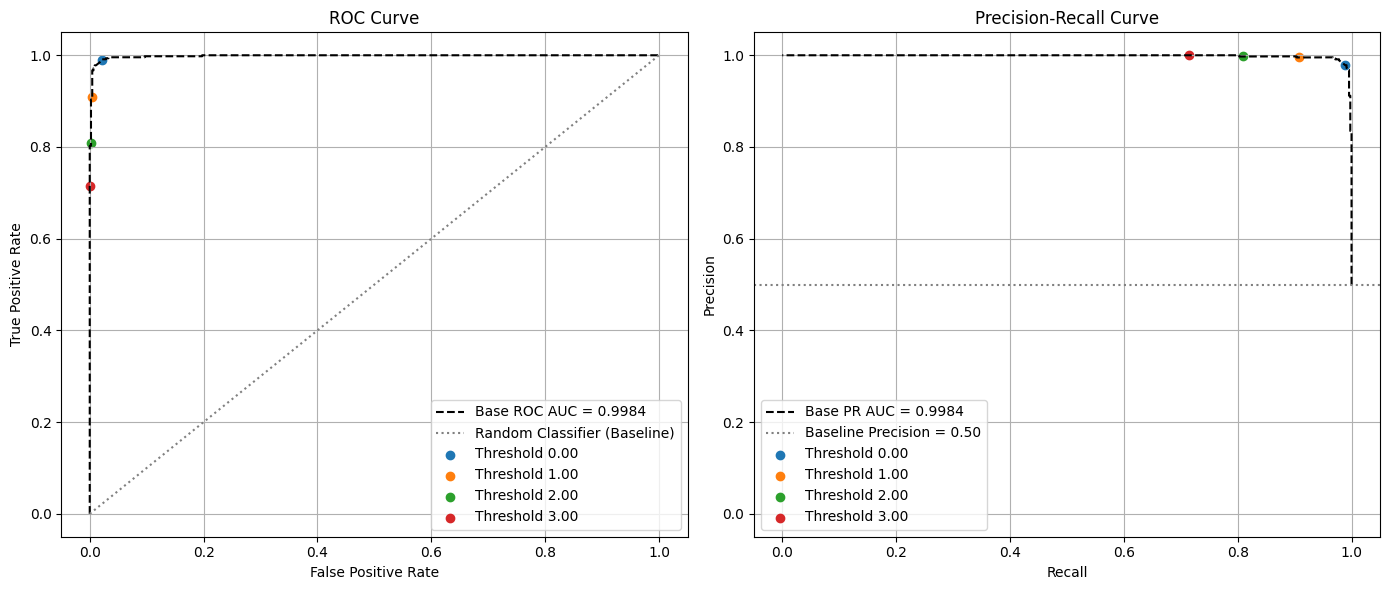

In [33]:
output = evaluate_thresholds_roc(player_scores_per_game, [0, 1, 2, 3])

In [34]:
with open("data/false_game_ids_threshold_3.pkl", "rb") as f:
    wrong_indices = pickle.load(f)
with open("data/games_not_trained_on.pkl", "rb") as f:
    val_games = list(pickle.load(f))

In [36]:
lengths = 0
long_wrong_games = []
for game in wrong_indices:
    game_messages = []
    game_data = chat_data[game]
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        game_messages.append(message["message"])
    print(len(game_messages))
    lengths += len(game_messages)
    if len(game_messages) >= 10:
        long_wrong_games.append(game)

print(lengths/len(wrong_indices))

1
1
3
3
6
1
1
1
1
4
4
8
5
5
4
4
2
2
2
2
2
2
2
2
2
2
3
3
10
2
2
1
1
1
1
9
3
3
6
6
3
3
5
5
5
6
3
3
1
1
7
7
2
2
17
12
12
3
3
5
5
3
3
6
6
3
3
2
2
1
1
6
7
6
6
4
4
2
2
1
1
3
3
3
3
2
2
3
3
2
2
11
4
8
6
3
3
6
2
2
6
6
3
3
3
3
3
3
3
3
1
1
8
8
8
12
12
3
3
2
2
7
3
3
17
4
4
5
4
4
4.0


In [39]:
print(long_wrong_games)

[3708, 3817, 3826, 3318, 3405, 2986, 2986, 3544]


The games were inspected on the website for further analysis. Go to e.g. https://play.turinggame.ai/chat/3708 to inspect them for yourself.

In [42]:
print(player_scores_per_game[val_games.index(3544)])

defaultdict(<class 'float'>, {'Yellow': -6.486389100551605, 'Purple': -2.1277358531951904, 'bot': 0.6864339113235474})


In [ ]:
print(len(wrong_indices))

130


In [46]:
classifier.predict("how's everyone?")

-0.8448495864868164